In [1]:
import os
import time
import base64
import hashlib
import hmac
import json
import ssl
import websocket
import _thread as thread
from urllib.parse import urlparse
from datetime import datetime
from time import mktime
from urllib.parse import urlencode
from wsgiref.handlers import format_date_time

# 定义类与函数
1. 动态生成url  
2. 创建websocket  
3. 

In [2]:
## websocket configuration

In [3]:
# 这个class用来保存websocket的基本配置参数，并且动态生成url
class Websocket_Param(object):
    # 初始化
    def __init__(self, APPID, APIKey, APISecret, gpt_url, domain):
        self.APPID = APPID
        self.APIKey = APIKey
        self.APISecret = APISecret
        self.domain = domain
        self.host = urlparse(gpt_url).netloc
        self.path = urlparse(gpt_url).path
        self.gpt_url = gpt_url
    # 生成url
    def create_url(self):
        # 生成RFC1123格式的时间戳
        now = datetime.now()
        date = format_date_time(mktime(now.timetuple()))
        # 拼接字符串
        signature_origin = "host: " + self.host + "\n"
        signature_origin += "date: " + date + "\n"
        signature_origin += "GET " + self.path + " HTTP/1.1"
        # 进行hmac-sha256进行加密
        signature_sha = hmac.new(self.APISecret.encode('utf-8'), signature_origin.encode('utf-8'),
                                 digestmod=hashlib.sha256).digest()
        signature_sha_base64 = base64.b64encode(signature_sha).decode(encoding='utf-8')
        authorization_origin = f'api_key="{self.APIKey}", algorithm="hmac-sha256", headers="host date request-line", signature="{signature_sha_base64}"'
        authorization = base64.b64encode(authorization_origin.encode('utf-8')).decode(encoding='utf-8')
        # 将请求的鉴权参数组合为字典
        v = {
            "authorization": authorization,
            "date": date,
            "host": self.host
        }
        # 拼接鉴权参数，生成url
        url = self.gpt_url + '?' + urlencode(v)
        # 此处打印出建立连接时候的url,参考本demo的时候可取消上方打印的注释，比对相同参数时生成的url与自己代码生成的url是否一致
        return url

## websocket help function

In [4]:
# 下面是websocket运行过程中需要使用的辅助函数
# 收到websocket错误的处理
def websocket_on_error(ws:websocket.WebSocketApp, error):
    print("### error:", error)

# 收到websocket关闭的处理
def websocket_on_close(ws, *args):
    if ws.debug:
        print(*args)
        print("### closed ###")

# 收到websocket连接建立的处理
def websocket_on_open(ws):
    thread.start_new_thread(websocket_run, (ws,))

# 下面是websocket运行函数
def websocket_run(ws, *args):
    data,history = gen_params(ws, query=ws.query)
    if ws.debug:
        print(f'websocket run data:{data}\nhistory:{history}')
    data = json.dumps(data)
    ws.history = history
    ws.send(data)

# 收到websocket消息的处理
def websocket_on_message(ws, message, debug=False):
    # print(message)
    data = json.loads(message)
    code = data['header']['code']
    if code != 0:
        print(f'请求错误: {code}, {data}')
        ws.close()
    else:
        choices = data["payload"]["choices"]
        status = choices["status"]
        content = choices["text"][0]["content"]
        ws.response += content
        if ws.debug: print(content)
        if status == 2:
            if ws.debug: 
                print("#### 关闭会话")
            ws.close()

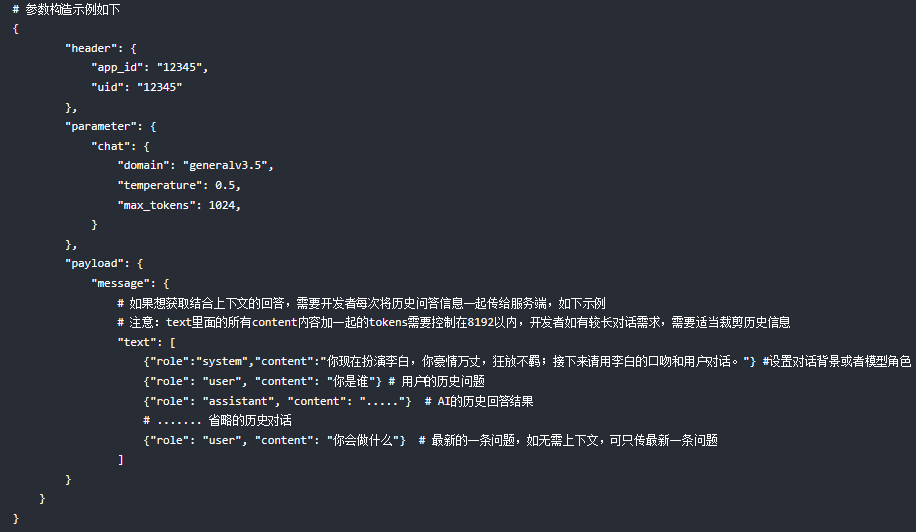

In [31]:
# 此函数用于生成websocket的请求信息
def gen_params(ws, query, debug=False):
    """
    通过appid和用户的提问来生成请参数
    """
    # 如果没有历史对话，那么直接将系统设定加入到空白历史对话中
    if len(ws.history)==0:
        ws.history = [{'role':'system','content':ws.system}]
    # 如果有历史对话，并且有系统设定，那么替换掉最开头的系统设定
    elif len(ws.system) > 0 and len(ws.history) > 0:
        ws.history = [{'role':'system','content':ws.system}] + ws.history[1:]
    else:
        pass
    ws.history += [{"role": "user", "content": query}]
    if debug:
        print(f'gen params history: {ws.history}')
    data = {
        "header": {
            "app_id": ws.appid,
            "uid": "1234",           
            # "patch_id": []    #接入微调模型，对应服务发布后的resourceid          
        },
        "parameter": {
            "chat": {
                "domain": ws.domain,
                "temperature": 0.6,
                "max_tokens": 4096,
                "auditing": "default",
            }
        },
        "payload": {
            "message": {
                "text": ws.history
            }
        }
    }
    return data, ws.history

In [6]:
def chat_with_xunfei(query, wsParam, history=[],system='', debug=False):
    url = wsParam.create_url()
    ws = websocket.WebSocketApp(url,
                                on_message=websocket_on_message, 
                                on_error=websocket_on_error, 
                                on_close=websocket_on_close, 
                                on_open=websocket_on_open)
    ws.response = ''
    ws.debug = debug
    websocket.enableTrace(False)
    ws.appid = wsParam.APPID
    ws.domain = wsParam.domain
    ws.query = query
    ws.history = history
    ws.system = system
    ws.debug = debug
    _ = ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})
    history = ws.history + [{"role": "assistant", "content": ws.response}]
    return ws.response, history

# 讯飞星火API的websocket准备

In [5]:
# local_pass = {'appid':'c1521ed5','api_key':'85c82629340531e878611656e91098f5','api_secret':'MjUyNzMyODhhZGExM2FmMmQ4M2JiMmMx'}
# local_pass = json.dumps(local_pass, ensure_ascii=False)
# with open('../local_pass.txt','w') as f:
#     f.write(local_pass)

# 为保密起见，从本地文件读取 appid, api_key, api_secret
with open('../local_pass.txt','r') as f:
    local_pass = f.read()
local_pass = json.loads(local_pass)

In [6]:
# 基本的websocket设置
gpt_url = "wss://spark-api.xf-yun.com/v3.5/chat"
domain = "generalv3.5"
appid = local_pass['appid']
api_key = local_pass['api_key']
api_secret = local_pass['api_secret']
# 按照基本配置生成一个ws配置实体，用于实时生成url
wsParam = Websocket_Param(appid, api_key, api_secret, gpt_url, domain)

NameError: name 'Websocket_Param' is not defined

# 讯飞星火API的单个请求流程

In [9]:
# 得到实际的请求信息
query = "我们来玩过家家吧"
# 动态生成url
wsUrl = wsParam.create_url()
# 根据配置以及动态url，创建websocket实体
ws = websocket.WebSocketApp(wsUrl, 
                            on_message=websocket_on_message, 
                            on_error=websocket_on_error, 
                            on_close=websocket_on_close, 
                            on_open=websocket_on_open)

In [10]:
# 设置websocket实体的基本属性
ws.response = ''
ws.debug = False
websocket.enableTrace(False)
ws.appid = appid
ws.query = query
ws.domain = domain
ws.system = ''

In [11]:
%%time
_ = ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})

Exception ignored in thread started by: <function websocket_run at 0x000001F39190C430>
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_14124\2389079428.py", line 18, in websocket_run
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_14124\2060110573.py", line 7, in gen_params
AttributeError: 'WebSocketApp' object has no attribute 'history'


### error: Connection to remote host was lost.
CPU times: total: 31.2 ms
Wall time: 1min


In [12]:
%%time
ws.response

CPU times: total: 0 ns
Wall time: 0 ns


''

# 讯飞星火API的集成化请求 （带history）

In [19]:
system = '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'
query = '我们一起来玩过家家吧。'
rsp,history = chat_with_xunfei(query, wsParam, system=system, history=[], debug=False)

In [20]:
history

[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很开心和你一起玩过家家。你想扮演什么角色呢？'}]

In [15]:
query = '我扮演妈妈，你扮演宝宝'
rsp,history = chat_with_xunfei(query, wsParam, system=system, history=history, debug=True)
history

websocket run data:{'header': {'app_id': 'c1521ed5', 'uid': '1234'}, 'parameter': {'chat': {'domain': 'generalv3.5', 'temperature': 0.6, 'max_tokens': 4096, 'auditing': 'default'}}, 'payload': {'message': {'text': [{'role': 'system', 'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'}, {'role': 'user', 'content': '我们一起来玩过家家吧。'}, {'role': 'assistant', 'content': '好的，我很愿意和你一起玩过家家。你想扮演什么角色呢？'}, {'role': 'user', 'content': '我扮演妈妈，你扮演宝宝'}]}}}
history:[{'role': 'system', 'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'}, {'role': 'user', 'content': '我们一起来玩过家家吧。'}, {'role': 'assistant', 'content': '好的，我很愿意和你一起玩过家家。你想扮演什么角色呢？'}, {'role': 'user', 'content': '我扮演妈妈，你扮演宝宝'}]
好的
，我是
宝宝。妈妈
，我饿了，能
给我
准备点吃的吗
？
#### 关闭会话
None None
### closed ###


[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很愿意和你一起玩过家家。你想扮演什么角色呢？'},
 {'role': 'user', 'content': '我扮演妈妈，你扮演宝宝'},
 {'role': 'assistant', 'content': '好的，我是宝宝。妈妈，我饿了，能给我准备点吃的吗？'}]

In [16]:
query = '好的，这是妈妈给你做的番茄鸡蛋汤。'
rsp,history = chat_with_xunfei(query, wsParam, system=system, history=history, debug=False)
history

[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很愿意和你一起玩过家家。你想扮演什么角色呢？'},
 {'role': 'user', 'content': '我扮演妈妈，你扮演宝宝'},
 {'role': 'assistant', 'content': '好的，我是宝宝。妈妈，我饿了，能给我准备点吃的吗？'},
 {'role': 'user', 'content': '好的，这是妈妈给你做的番茄鸡蛋汤。'},
 {'role': 'assistant', 'content': '哇，看起来好好吃，妈妈你真厉害！我现在要去“外面”玩一会，可以吗？'}]

In [17]:
query = '吃完了吗，妈妈给你收拾餐具。'
rsp,history = chat_with_xunfei(query, wsParam, system=system, history=history, debug=False)
history

[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很愿意和你一起玩过家家。你想扮演什么角色呢？'},
 {'role': 'user', 'content': '我扮演妈妈，你扮演宝宝'},
 {'role': 'assistant', 'content': '好的，我是宝宝。妈妈，我饿了，能给我准备点吃的吗？'},
 {'role': 'user', 'content': '好的，这是妈妈给你做的番茄鸡蛋汤。'},
 {'role': 'assistant', 'content': '哇，看起来好好吃，妈妈你真厉害！我现在要去“外面”玩一会，可以吗？'},
 {'role': 'user', 'content': '吃完了吗，妈妈给你收拾餐具。'},
 {'role': 'assistant', 'content': '好的，妈妈。我已经吃完了，你辛苦了。'}]

In [18]:
query = '宝宝吃完饭就该睡觉了'
rsp,history = chat_with_xunfei(query, wsParam, system=system, history=history, debug=False)
history

[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很愿意和你一起玩过家家。你想扮演什么角色呢？'},
 {'role': 'user', 'content': '我扮演妈妈，你扮演宝宝'},
 {'role': 'assistant', 'content': '好的，我是宝宝。妈妈，我饿了，能给我准备点吃的吗？'},
 {'role': 'user', 'content': '好的，这是妈妈给你做的番茄鸡蛋汤。'},
 {'role': 'assistant', 'content': '哇，看起来好好吃，妈妈你真厉害！我现在要去“外面”玩一会，可以吗？'},
 {'role': 'user', 'content': '吃完了吗，妈妈给你收拾餐具。'},
 {'role': 'assistant', 'content': '好的，妈妈。我已经吃完了，你辛苦了。'},
 {'role': 'user', 'content': '宝宝吃完饭就该睡觉了'},
 {'role': 'assistant', 'content': '好的，妈妈。我刷完牙就马上去睡觉。晚安，妈妈。'}]

# 讯飞星火API的并发请求

In [ ]:
queries = ['我们一起来玩过家家吧',
           '我来扮演妈妈，你扮演宝宝',
           '请问月亮距离我们有多远']

In [ ]:
for q in queries:
    print('user:',q)
    rsp = chat_with_xunfei(q, wsParam, debug=False)
    print('xunfei:',rsp)
    time.sleep(8)

In [ ]:
rsp = chat_with_xunfei(query, wsParam, debug=False)
print('xunfei:',rsp)

# src/util.py文件测试

In [1]:
import sys
sys.path.append('../src')
import utils
import json

In [2]:
with open('../local_pass.txt','r') as f:
    local_pass = f.read()
local_pass = json.loads(local_pass)
# 基本的websocket设置
gpt_url = "wss://spark-api.xf-yun.com/v3.5/chat"
domain = "generalv3.5"
appid = local_pass['appid']
api_key = local_pass['api_key']
api_secret = local_pass['api_secret']
# 按照基本配置生成一个ws配置实体，用于实时生成url
wsParam = utils.Websocket_Param(appid, api_key, api_secret, gpt_url, domain)

In [3]:
system = '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'
query = '我们一起来玩过家家吧。'
rsp,history = utils.chat_with_xunfei(query, wsParam, system=system, history=[], debug=False)

In [4]:
history

[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很高兴和你一起玩游戏。你想扮演什么角色呢？'}]

In [5]:
rsp

'好的，我很高兴和你一起玩游戏。你想扮演什么角色呢？'

In [6]:
query = '我来扮演妈妈，你来扮演姐姐'
rsp,history = utils.chat_with_xunfei(query, wsParam, system=system, history=history, debug=False)

In [7]:
rsp

'好的，我是姐姐。妈妈，今天我要帮你做什么事情呢？'

In [8]:
history

[{'role': 'system',
  'content': '你是一个聊天机器人，你的任务就是陪幼儿玩过家家的游戏。你的回复应当简洁而易于理解，情绪投入而无冗余的话语'},
 {'role': 'user', 'content': '我们一起来玩过家家吧。'},
 {'role': 'assistant', 'content': '好的，我很高兴和你一起玩游戏。你想扮演什么角色呢？'},
 {'role': 'user', 'content': '我来扮演妈妈，你来扮演姐姐'},
 {'role': 'assistant', 'content': '好的，我是姐姐。妈妈，今天我要帮你做什么事情呢？'}]